In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baixando as bibliotecas

In [2]:
!pip install mlforecast dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


# Importando as bibliotecas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoRandomForest,
    AutoLinearRegression,
    AutoElasticNet
)

import warnings
warnings.filterwarnings('ignore')

# Funcoes

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      non_zero_idx = y_true != 0
      return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Carregando os dados

In [5]:
bucket_uri = "/content/drive/MyDrive/M5_full.parquet"   

In [6]:
dados = pd.read_parquet(bucket_uri)

In [7]:
dados['date'] = pd.to_datetime(dados['date'])

### Foi necessário remover o mês por não ser um mês completo e estava atrapalhando nas previsões

In [8]:
ano = 2016
mes = 5

dados = dados[~((dados['date'].dt.year == ano) & (dados['date'].dt.month == mes))]

In [9]:
dados.set_index('date', inplace=True)

# Criando a série de valor total

In [10]:
dados = dados.drop(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis=1)

In [11]:
valor_total = dados.resample("MS").sum()

## Split em treino e teste

In [12]:
teste_size = 6
teste = valor_total.tail(teste_size)
train = valor_total.drop(teste.index)

In [13]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [14]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y'})

In [15]:
df_train['unique_id'] = 0
df_test['unique_id'] = 0

## Analisando o melhor modelo para a previsão

In [31]:
models={
    'lgb': AutoLightGBM(),
    'linear_regression': AutoLinearRegression(),
    'elastic_net': AutoElasticNet(),
    'rf' : AutoRandomForest()
    }

In [32]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=6,
)

In [45]:
auto_mlf.fit(
    df_train,
    n_windows=3,
    h=6,
    num_samples=6,
)

[I 2024-07-10 23:51:11,431] A new study created in memory with name: no-name-1c5301a1-fdeb-41d3-9aad-4aa68a134b4b
[I 2024-07-10 23:51:11,646] Trial 0 finished with value: 0.05246992733158944 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 2}. Best is trial 0 with value: 0.05246992733158944.
[I 2024-07-10 23:51:12,125] Trial 1 finished with value: 0.06536111564238915 and parameters: {'n_estimators': 920, 'lambda_l1': 0.15574964948467418, 'lambda_l2': 0.00014233583723829364, 'num_leaves': 722, 'feature_fraction': 0.5591372129344666, 'bagging_fraction': 0.819960510663762, 'objective': 'l2', 'target_transforms_idx': 3, 'lags_idx': 0, 'lag_transforms_idx': 1}. Best is trial 0 with value: 0.05246992733158944.
[I 2024-07-10 23:51:12,346] Trial 2 finishe

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'linear_regression': AutoModel(model=LinearRegression), 'elastic_net': AutoModel(model=ElasticNet), 'rf': AutoModel(model=RandomForestRegressor)})

In [46]:
preds = auto_mlf.predict(6)

In [47]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

## Analisando o resultado dos modelos por gráficos

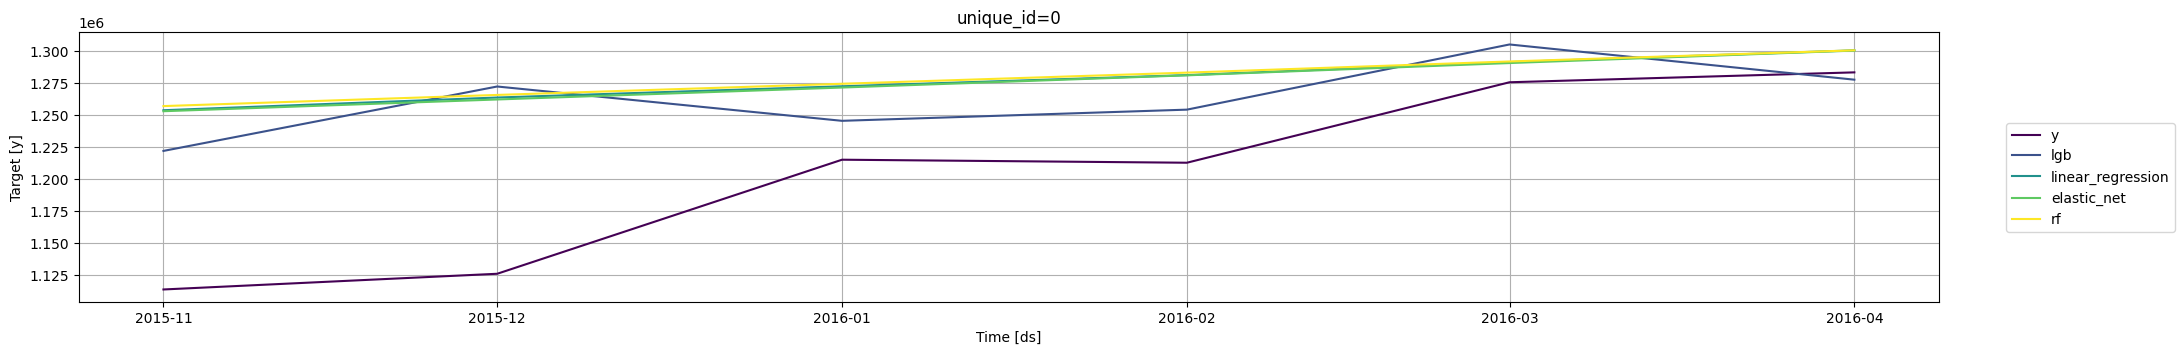

In [48]:
plot_series(df_test, preds, plot_random=False)

## Validando as métricas

In [49]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [50]:
previsao_full

,ds,y,unique_id,lgb,linear_regression,elastic_net,rf
0,2015-11-01,1113976,0,1222146,1253916,1253133,1257145
1,2015-12-01,1126236,0,1272436,1263843,1262308,1265853
2,2016-01-01,1215286,0,1245640,1272623,1271626,1274561
3,2016-02-01,1212927,0,1254370,1281342,1281150,1283270
4,2016-03-01,1275746,0,1305250,1291479,1290745,1291978
5,2016-04-01,1283470,0,1277763,1300658,1300497,1300686


In [51]:
for i in list(models.keys()):
  print(f'----------------{i}-------------------')
  MAE = mean_absolute_error(previsao_full['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(previsao_full['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(previsao_full[i], previsao_full['y']))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(previsao_full['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

----------------lgb-------------------
Mean Absolute Error: 60229.666666666664
Mean absolute percentage error: 5.227226049652311
Root mean squared error: 78120.77437105532
R2: -0.4182031004214366


----------------linear_regression-------------------
Mean Absolute Error: 72703.33333333333
Mean absolute percentage error: 6.285235381084636
Root mean squared error: 88534.35159680487
R2: -0.8214991514997108


----------------elastic_net-------------------
Mean Absolute Error: 71969.66666666667
Mean absolute percentage error: 6.222813659246329
Root mean squared error: 87772.16898690989
R2: -0.7902719718590434


----------------rf-------------------
Mean Absolute Error: 74308.66666666667
Mean absolute percentage error: 6.4232440688723536
Root mean squared error: 90380.49292113131
R2: -0.898255917877097




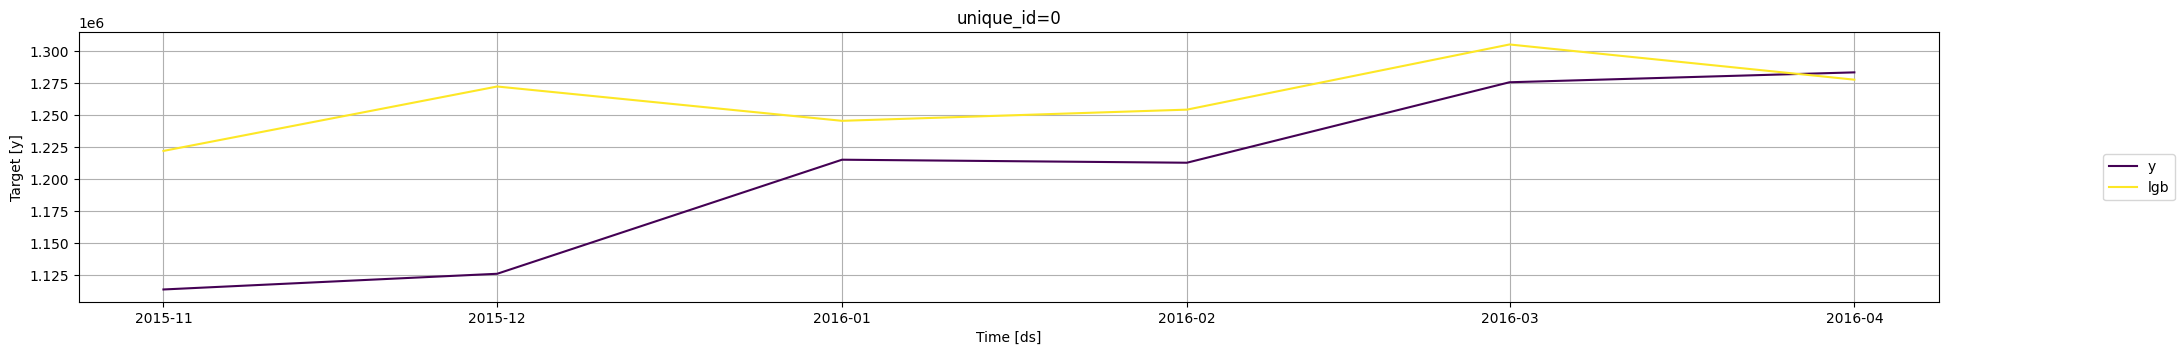

In [52]:
plot_series(df_test, preds[['unique_id', 'ds', 'lgb']], plot_random=False)

In [53]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'lgb']]

## Fazendo a previsão para os próximos 6 meses

In [54]:
dados_full = pd.concat([df_train, df_test])

In [55]:
models_full ={
    'lgb': AutoLightGBM()
        }

In [56]:
auto_mlf_full = AutoMLForecast(
    models=models_full,
    freq="MS",
    season_length=6,
)

In [57]:
auto_mlf_full.fit(
    dados_full,
    n_windows=3,
    h=6,
    num_samples=6,
)

[I 2024-07-10 23:52:02,638] A new study created in memory with name: no-name-5661faa2-3b4e-4a7e-bb36-aac735f0f4dd
[I 2024-07-10 23:52:02,852] Trial 0 finished with value: 0.0573144961213212 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 2}. Best is trial 0 with value: 0.0573144961213212.
[I 2024-07-10 23:52:03,098] Trial 1 finished with value: 0.0324929093690792 and parameters: {'n_estimators': 920, 'lambda_l1': 0.15574964948467418, 'lambda_l2': 0.00014233583723829364, 'num_leaves': 722, 'feature_fraction': 0.5591372129344666, 'bagging_fraction': 0.819960510663762, 'objective': 'l2', 'target_transforms_idx': 3, 'lags_idx': 0, 'lag_transforms_idx': 1}. Best is trial 1 with value: 0.0324929093690792.
[I 2024-07-10 23:52:03,236] Trial 2 finished wi

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor)})

In [58]:
preds_full = auto_mlf_full.predict(6)

In [59]:
for i in list(models_full.keys()):
  preds_full[i] = preds_full[i].astype(int)

# Exportando os arquivos

# Exportando o pickle

In [61]:
# with open('valores.pkl', 'wb') as f:
#     pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [62]:
# preds_full.to_csv('previsao_valor.csv', index=False)

# Validação

In [ ]:
# tabela_validacao.to_csv('validacao_valor.csv', index=False)